In [380]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy, levene
from tqdm.auto import tqdm
import seaborn as sns
from nltk.tokenize import word_tokenize, sent_tokenize
import collections as coll
import math
import spacy
import os

In [381]:
all_liwc_features = [
    "Analytic",
    "Clout",
    "Authentic",
    "Tone",
    "WPS",
    "BigWords",
    "Dic",
    "Linguistic",
    "function",
    "pronoun",
    "ppron",
    "i",
    "we",
    "you",
    "shehe",
    "they",
    "ipron",
    "det",
    "article",
    "number",
    "prep",
    "auxverb",
    "adverb",
    "conj",
    "negate",
    "verb",
    "adj",
    "quantity",
    "Drives",
    "affiliation",
    "achieve",
    "power",
    "Cognition",
    "allnone",
    "cogproc",
    "insight",
    "cause",
    "discrep",
    "tentat",
    "certitude",
    "differ",
    "memory",
    "Affect",
    "tone_pos",
    "tone_neg",
    "emotion",
    "emo_pos",
    "emo_neg",
    "emo_anx",
    "emo_anger",
    "emo_sad",
    "swear",
    "Social",
    "socbehav",
    "prosocial",
    "polite",
    "conflict",
    "moral",
    "comm",
    "socrefs",
    "family",
    "friend",
    "female",
    "male",
    "Culture",
    "politic",
    "ethnicity",
    "tech",
    "Lifestyle",
    "leisure",
    "home",
    "work",
    "money",
    "relig",
    "Physical",
    "health",
    "illness",
    "wellness",
    "mental",
    "substances",
    "sexual",
    "food",
    "death",
    "need",
    "want",
    "acquire",
    "lack",
    "fulfill",
    "fatigue",
    "reward",
    "risk",
    "curiosity",
    "allure",
    "Perception",
    "attention",
    "motion",
    "space",
    "visual",
    "auditory",
    "feeling",
    "time",
    "focuspast",
    "focuspresent",
    "focusfuture",
    "Conversation",
    "netspeak",
    "assent",
    "nonflu",
    "filler",
    "AllPunc",
    "Period",
    "Comma",
    "QMark",
    "Exclam",
    "Apostro",
    "OtherP",
    "Emoji",
]

complexity_features = [
    # "avg_dependency_link_length",
    # "type_token_ratio",
    # "hapax_legemena",
    # "shannon_entropy",
    # "simpsons_index",
]

In [382]:
DATASET_TO_DATASET_NAME = {
    "essays": "Essays",
    "wassa": "Empathetic C.",
    "facebook": "YourMorals",
    "political": "Congress",
}

BASELINES = {
    "CON": 0.5110732538330494,
    "EXT": 0.5157580919931857,
    "AGR": 0.530664395229983,
    "NEU": 0.5008517887563884,
    "OPN": 0.5161839863713799,
    ".care": 0.5070035704476792,
    ".purity": 0.5358418017028289,
    ".fairness": 0.5281516067014557,
    ".loyalty": 0.5034331227684702,
    ".authority": 0.5339192529524857,
    ".iri.concern": 0.5724331926863573,
    ".iri.distress": 0.5175808720112518,
    ".iri.fantasy": 0.5471167369901547,
    ".iri.perspective": 0.5274261603375527,
    "gender": 0.5,
    "cohort": 0.25,
    "party": 0.5,
}


FROM_CURRENT_TO_ORDERED_AGE_GROUP_INDICES = {
    0: 3,
    1: 1,
    2: 0,
    3: 2,
}


DATASET_TO_BASELINES = {
    "essays": np.mean([BASELINES[x] for x in ["CON", "EXT", "AGR", "NEU", "OPN"]]),
    "wassa": np.mean(
        [
            BASELINES[x]
            for x in [
                ".iri.concern",
                ".iri.distress",
                ".iri.fantasy",
                ".iri.perspective",
            ]
        ]
    ),
    "wassa_individual": np.mean(
        [
            BASELINES[x]
            for x in [
                ".iri.concern",
                ".iri.distress",
                ".iri.fantasy",
                ".iri.perspective",
            ]
        ]
    ),
    "facebook": np.mean(
        [
            BASELINES[x]
            for x in [".care", ".purity", ".fairness", ".loyalty", ".authority"]
        ]
    ),
    "party": BASELINES["party"],
    "gender": BASELINES["gender"],
    "cohort": BASELINES["cohort"],
}

REWRITTEN_TYPE_TO_SHORT = {
    "syntax_grammar": "SG",
    "rephrase": "R",
}

LLM_TO_NAME = {
    "original": "Original",
    "gpt": "GPT3.5",
    "llama": "Llama 2",
    "gemini": "Gemini",
}

LABELS_TO_NAME = {
    ".iri.concern": "Concern",
    ".iri.distress": "Distress",
    ".iri.perspective": "Perspective",
    ".iri.fantasy": "Fantasy",
    ".authority": "Authority",
    ".care": "Care",
    ".fairness": "Fairness",
    ".loyalty": "Loyalty",
    ".purity": "Purity",
    "CON": "CON",
    "NEU": "NEU",
    "EXT": "EXT",
    "AGR": "AGR",
    "OPN": "OPN",
    "gender": "Gender",
    "cohort": "Age group",
    "party": "Party",
}

In [383]:
personality_columns = [
    "nrc.negative",
    "emo_pos",
    "affect",
    "nrc.positive",
    "affiliation",
    "emotion",
    "nrc.joy",
    "social",
    "emo_sad",
    "nrc.anticipation",
    "nrc.anger",
    "pronoun",
    "i",
    "emo_anger",
    "swear",
    "bigwords",
    "emo_neg",
    "nrc.disgust",
    "nrc.sadness",
    "nrc.trust",
]

In [384]:
facebook_columns = [
    "we",
    "socrefs",
    "pronoun",
    "friend",
    "mfd.authority.virtue",
    "mfd.care.virtue",
    "affect",
    "i",
    "mfd.authority.vice",
    "mfd.purity.vice",
    "affiliation",
    "prosocial",
    "family",
    "religion",
    "mfd.purity.virtue",
    "you",
    "social",
]

In [385]:
wassa_columns = [
    "affect",
    "differ",
    "we",
    "she,he",
    "pronoun",
    "emo_neg",
    "tentat",
    "empathy.low",
    "pronoun",
    "cogproc",
    "distress.low",
]

In [386]:
political_columns = [
    "mfd.authority.virtue",
    "mfd.authority.vice",
    "mfd.loyalty.virtue",
    "mfd.loyalty.vice",
    "mfd.fairness.virtue",
    "mfd.fairness.vice",
    "emo_anx",
    "adverb",
    "conj",
    "emo_neg",
    "emo_anger",
    "we",
    "relig",
    "swear",
    "i",
    "cogproc",
    "emo_pos",
    "certitude",
]

gender_columns = [
    "article",
    "social",
    "emo_anx",
    "pronoun",
    "i",
    "emo_pos",
    "emo_neg",
    "affect",
    "tentat",
    "motion",
    "swear",
    "quant",
    "number",
    "space",
    "cogproc",
]

age_columns = [
    "we",
    "cogproc",
    "prep",
    "article",
    "social",
    "focusfuture",
    "focuspast",
    "emo_neg",
    "emo_pos",
    "i",
]

In [387]:
nlp = spacy.load("en_core_web_sm")


def RemoveSpecialCHs(text):
    text = word_tokenize(text)
    st = [
        ",",
        ".",
        "'",
        "!",
        '"',
        "#",
        "$",
        "%",
        "&",
        "(",
        ")",
        "*",
        "+",
        "-",
        ".",
        "/",
        ":",
        ";",
        "<",
        "=",
        ">",
        "?",
        "@",
        "[",
        "\\",
        "]",
        "^",
        "_",
        "`",
        "{",
        "|",
        "}",
        "~",
        "\t",
        "\n",
    ]

    words = [word for word in text if word not in st]
    return words


def compute_avg_dependency_link_length(text):
    try:
        doc = nlp(text)
        link_lengths = []
        for sent in doc.sents:
            sent_link_lengths = []
            for token in sent:
                if token.dep_ != "ROOT":
                    head = token.head
                    sent_link_lengths.append(abs(head.i - token.i))
            if sent_link_lengths:  # Only append if sentence had any links
                link_lengths.append(np.mean(sent_link_lengths))
        return np.mean(link_lengths)
    except:
        return np.nan


def typeTokenRatio(text):
    try:
        words = word_tokenize(text)
        return len(set(words)) / len(words)
    except:
        return np.nan


def hapaxLegemena(text):
    try:
        words = RemoveSpecialCHs(text)
        V1 = 0
        # dictionary comprehension . har word kay against value 0 kardi
        freqs = {key: 0 for key in words}
        for word in words:
            freqs[word] += 1
        for word in freqs:
            if freqs[word] == 1:
                V1 += 1
        N = len(words)
        V = float(len(set(words)))
        R = 100 * math.log(N) / max(1, (1 - (V1 / V)))
        h = V1 / N
        return R, h
    except:
        return np.nan, np.nan


def ShannonEntropy(text):
    try:
        words = RemoveSpecialCHs(text)
        lenght = len(words)
        freqs = coll.Counter()
        freqs.update(words)
        arr = np.array(list(freqs.values()))
        distribution = 1.0 * arr
        distribution /= max(1, lenght)
        import scipy as sc

        H = sc.stats.entropy(distribution, base=2)
        # H = sum([(i/lenght)*math.log(i/lenght,math.e) for i in freqs.values()])
        return H
    except:
        return np.nan


def SimpsonsIndex(text):
    try:
        words = RemoveSpecialCHs(text)
        freqs = coll.Counter()
        freqs.update(words)
        N = len(words)
        n = sum([1.0 * i * (i - 1) for i in freqs.values()])
        D = 1 - (n / (N * (N - 1)))
        return D
    except:
        return np.nan

In [388]:
def add_complexity_features(df):
    df["avg_dependency_link_length"] = [
        compute_avg_dependency_link_length(text)
        for text in tqdm(df["text"], leave=False)
    ]

    df["type_token_ratio"] = [
        typeTokenRatio(text) for text in tqdm(df["text"], leave=False)
    ]
    df["hapax_legemena"] = [
        hapaxLegemena(text)[1] for text in tqdm(df["text"], leave=False)
    ]
    df["shannon_entropy"] = [
        ShannonEntropy(text) for text in tqdm(df["text"], leave=False)
    ]
    df["simpsons_index"] = [
        SimpsonsIndex(text) for text in tqdm(df["text"], leave=False)
    ]
    return df


def add_complexity_features_to_dataset(dataset):
    dataset.set_original_data(add_complexity_features(dataset.get_original_data()))
    for llm in tqdm(["gpt", "llama", "gemini"], leave=False):
        for mode in tqdm(["syntax_grammar", "rephrase"], leave=False):
            dataset.set_rewritten_data(
                mode,
                llm,
                add_complexity_features(dataset.get_rewritten_data(mode, llm)),
            )

    return dataset


def does_dataset_have_complexity_features(dataset):
    return all(
        [
            feature in dataset.get_original_data().columns
            for feature in complexity_features
        ]
    )

In [389]:
class Dataset:
    def __init__(self) -> None:
        self.filtered_columns = all_liwc_features + complexity_features
        self.rewritten_datasets = {}

    def get_original_data(self):
        return self.original_data

    def set_original_data(self, data):
        self.original_data = data
        data.to_csv(self.original_data_path, index=False)

    def get_rewritten_data(self, n, m):
        if self.rewritten_datasets.get((n, m)) is None:
            self.rewritten_datasets[(n, m)] = pd.read_csv(
                self.rewritten_data_path.format(n, m)
            )
        return self.rewritten_datasets[(n, m)]

    def set_rewritten_data(self, n, m, data):
        self.rewritten_datasets[(n, m)] = data
        data.to_csv(self.rewritten_data_path.format(n, m), index=False)


class Essays(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.original_data_path = "essays/with_dictionaries/LIWC-22 Results - essays_anon_full - LIWC Analysis.csv"
        self.rewritten_data_path = "essays/with_dictionaries/LIWC-22 Results - essays_rewritten_{}_{} - LIWC Analysis.csv"
        self.original_data = pd.read_csv(self.original_data_path)
        self.id_column = "#AUTHID"
        self.filtered_columns = self.filtered_columns + [
            col for col in self.original_data.columns if "nrc." in col
        ]

    def get_original_data(self):
        # call the parent class method to get the original data
        return super().get_original_data()

    def get_rewritten_data(self, n, m):
        return super().get_rewritten_data(n, m)


class Wassa(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.original_data_path = (
            "wassa/with_dictionaries/LIWC-22 Results - clean_wassa - LIWC Analysis.csv"
        )
        self.rewritten_data_path = "wassa/with_dictionaries/LIWC-22 Results - wassa_rewritten_{}_{} - LIWC Analysis.csv"
        self.original_data = pd.read_csv(self.original_data_path)
        self.id_column = "id"
        self.filtered_columns = self.filtered_columns + [
            col
            for col in self.original_data.columns
            if col.split(".") in ["distress", "empathy"]
        ]

    def get_original_data(self):
        return super().get_original_data()

    def get_rewritten_data(self, n, m):
        return super().get_rewritten_data(n, m)


class Political(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.original_data_path = "political/with_dictionaries_both/LIWC-22 Results - clean_data_agg - LIWC Analysis.csv"
        self.rewritten_data_path = "political/with_dictionaries_both/LIWC-22 Results - political_rewritten_{}_{} - LIWC Analysis.csv"
        self.original_data = pd.read_csv(self.original_data_path)
        self.id_column = "speakerid"

    def get_original_data(self):
        return super().get_original_data()

    def get_rewritten_data(self, n, m):
        return super().get_rewritten_data(n, m)


class Facebook(Dataset):
    def __init__(self) -> None:
        super().__init__()
        self.original_data_path = "facebook/with_dictionaries/LIWC-22 Results - full_dataset_clean - LIWC Analysis.csv"
        self.rewritten_data_path = "facebook/with_dictionaries/LIWC-22 Results - facebook_rewritten_{}_{} - LIWC Analysis.csv"
        self.original_data = pd.read_csv(self.original_data_path)
        self.id_column = "subject_id"
        self.filtered_columns = self.filtered_columns + [
            col for col in self.original_data.columns if "mfd." in col
        ]

    def get_original_data(self):
        return super().get_original_data()

    def get_rewritten_data(self, n, m):
        return super().get_rewritten_data(n, m)

In [390]:
essays = Essays()
wassa = Wassa()
political = Political()
facebook = Facebook()

if not does_dataset_have_complexity_features(essays):
    print("Processing Essays dataset with the complexity features")
    essays = add_complexity_features_to_dataset(essays)
if not does_dataset_have_complexity_features(wassa):
    print("Processing Wassa dataset with the complexity features")
    wassa = add_complexity_features_to_dataset(wassa)
if not does_dataset_have_complexity_features(political):
    print("Processing Political dataset with the complexity features")
    political = add_complexity_features_to_dataset(political)
if not does_dataset_have_complexity_features(facebook):
    print("Processing Facebook dataset with the complexity features")
    facebook = add_complexity_features_to_dataset(facebook)

In [402]:
def get_agg_features_and_entropies():

    llms = []
    modes = []
    cols = []
    entropy_values = []
    distribution_values = []
    datasets = []
    dataset_original_or_not = []
    for dataset in tqdm([essays, wassa, political, facebook], leave=False):
        for llm in tqdm(["gpt", "llama", "gemini"], leave=False):
            for mode in tqdm(["syntax_grammar", "rephrase"], leave=False):
                for col in tqdm(dataset.filtered_columns, leave=False):

                    original_data = dataset.get_original_data()
                    rewritten_data = dataset.get_rewritten_data(mode, llm)

                    original_data = original_data[original_data[col].notna()]
                    rewritten_data = rewritten_data[rewritten_data[col].notna()]

                    shared_ids = list(
                        set.intersection(
                            set(original_data[dataset.id_column].tolist()),
                            set(rewritten_data[dataset.id_column].tolist()),
                        )
                    )

                    original_data = original_data[
                        original_data[dataset.id_column].isin(shared_ids)
                    ]
                    rewritten_data = rewritten_data[
                        rewritten_data[dataset.id_column].isin(shared_ids)
                    ]

                    original_data = original_data.set_index(
                        dataset.id_column
                    ).sort_index()[col]

                    rewritten_data = rewritten_data.set_index(
                        dataset.id_column
                    ).sort_index()[col]

                    # first remove the outliers
                    filtered_original_data = original_data[
                        (original_data < original_data.quantile(0.97))
                        & (original_data > original_data.quantile(0.03))
                    ]

                    filtered_rewritten_data = rewritten_data[
                        (rewritten_data < rewritten_data.quantile(0.97))
                        & (rewritten_data > rewritten_data.quantile(0.03))
                    ]

                    if len(filtered_original_data) >= 10:
                        original_data = filtered_original_data

                    if len(filtered_rewritten_data) >= 10:
                        rewritten_data = filtered_rewritten_data

                    max_original_rewritten_data = max(
                        max(original_data), max(rewritten_data)
                    )
                    min_original_rewritten_data = min(
                        min(original_data), min(rewritten_data)
                    )
                    original_data_normalized = (
                        original_data - min_original_rewritten_data
                    ) / (max_original_rewritten_data - min_original_rewritten_data)
                    rewritten_data_normalized = (
                        rewritten_data - min_original_rewritten_data
                    ) / (max_original_rewritten_data - min_original_rewritten_data)

                    for is_original in [True, False]:
                        dataset_original_or_not.append(is_original)
                        if is_original:
                            entropy_values.append(
                                entropy(original_data_normalized.value_counts().values)
                            )
                            distribution_values.append(
                                original_data_normalized.values.tolist()
                            )
                        else:
                            entropy_values.append(
                                entropy(rewritten_data_normalized.value_counts().values)
                            )
                            distribution_values.append(
                                rewritten_data_normalized.values.tolist()
                            )

                        llms.append(llm)
                        modes.append(mode)
                        cols.append(col)
                        datasets.append(
                            "essays"
                            if isinstance(dataset, Essays)
                            else (
                                "wassa"
                                if isinstance(dataset, Wassa)
                                else (
                                    "political"
                                    if isinstance(dataset, Political)
                                    else "facebook"
                                )
                            )
                        )
    return (
        llms,
        modes,
        cols,
        datasets,
        dataset_original_or_not,
        entropy_values,
        distribution_values,
    )

In [ ]:
(
    llms,
    modes,
    cols,
    datasets,
    dataset_original_or_not,
    entropy_values,
    distribution_values,
) = get_agg_features_and_entropies()
df = pd.DataFrame(
    {
        "llm": llms,
        "mode": modes,
        "col": cols,
        "dataset": datasets,
        "is_original": dataset_original_or_not,
        "entropy": entropy_values,
        "distribution": distribution_values,
    }
)
df["col"] = df["col"].str.lower()

In [404]:
df[(df["col"] == "swear") & (df["dataset"] == "political")]

,llm,mode,col,dataset,is_original,entropy,distribution
3030,gpt,syntax_grammar,swear,political,True,0.000000,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, ..."
3031,gpt,syntax_grammar,swear,political,False,0.280286,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3264,gpt,rephrase,swear,political,True,0.000000,"[0.15789473684210525, 0.15789473684210525, 0.1..."
3265,gpt,rephrase,swear,political,False,0.183780,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3498,llama,syntax_grammar,swear,political,True,0.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3499,llama,syntax_grammar,swear,political,False,0.000000,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
3732,llama,rephrase,swear,political,True,0.000000,"[0.14285714285714285, 0.14285714285714285, 0.1..."
3733,llama,rephrase,swear,political,False,0.159729,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3966,gemini,syntax_grammar,swear,political,True,0.000000,"[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3967,gemini,syntax_grammar,swear,political,False,0.167944,"[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ..."


In [406]:
def remove_outliers(curr_list):
    upper_quartile = np.percentile(curr_list, 95)
    lower_quartile = np.percentile(curr_list, 5)
    new_list = [x for x in curr_list if x < upper_quartile and x > lower_quartile]
    if len(new_list) == 0:
        return curr_list
    return new_list

In [407]:
def get_df_with_dist_spread(data):
    data_to_work_with = data.copy()
    new_is_original = []
    new_col = []
    new_values = []
    for index, row in data_to_work_with.iterrows():

        all_values_normalized = row["distribution"]

        for val in all_values_normalized:
            new_is_original.append("Original" if row["is_original"] else "Rewritten")
            new_col.append(row["col"])
            new_values.append(val)

    return pd.DataFrame(
        {
            "Text": new_is_original,
            "col": new_col,
            "value": new_values,
        }
    )

In [408]:
general_categories_that_are_reduced = [
    "pronoun",
    "affect",
    "emo_pos",
    "emo_anger",
    "emo_sad",
    "swear",
    "social",
    "death",
    "conversation",
    # "netspeak",
    "assent",
    "nonflu",
    "filler",
    "emo_anx",
    # so far so good
] + complexity_features

In [409]:
df.head(3)

,llm,mode,col,dataset,is_original,entropy,distribution
0,gpt,syntax_grammar,analytic,essays,True,7.194175,"[0.2346099859635051, 0.02646881892921596, 0.04..."
1,gpt,syntax_grammar,analytic,essays,False,7.232840,"[0.23721676358532184, 0.11229195909364346, 0.0..."
2,gpt,syntax_grammar,clout,essays,True,6.631778,"[0.7063997573551714, 0.5823475887170154, 0.004..."


In [410]:
general_categories_that_are_reduced

['pronoun',
 'affect',
 'emo_pos',
 'emo_anger',
 'emo_sad',
 'swear',
 'social',
 'death',
 'conversation',
 'assent',
 'nonflu',
 'filler',
 'emo_anx']

In [411]:
entropy_dfs = df[
    (df["mode"] == "rephrase")
    & (df["llm"] == "gpt")
    & (df["col"].isin(general_categories_that_are_reduced))
].drop(columns=["llm", "mode"])

# compute the variance of the distribution values and put them in variance
entropy_dfs["variance"] = entropy_dfs["distribution"].apply(lambda x: np.var(x))


def create_cell(x):
    # value should be the original variance and the rewritten variance in parantheses
    # also do the levene test for difference in variance between the distribution of two groups and if it's significant put a star next to the value in parantheses
    stat, p = levene(
        x["distribution"][x["is_original"]].values[0],
        x["distribution"][~x["is_original"]].values[0],
    )
    original_var = x["variance"][x["is_original"]].values[0]
    rewritten_var = x["variance"][~x["is_original"]].values[0]

    symbol = "↓" if original_var > rewritten_var else "↑"

    if p < 0.001:
        return f"{x['variance'][x['is_original']].values[0]:.4f} --> {x['variance'][~x['is_original'] ].values[0]:.4f} ({symbol}) & {stat:.4f} & {p:.4f} \\textsuperscript{{***}}"
    elif p < 0.05:
        return f"{x['variance'][x['is_original']].values[0]:.4f} --> {x['variance'][~x['is_original'] ].values[0]:.4f} ({symbol}) & {stat:.4f} & {p:.4f} \\textsuperscript{{*}}"
    else:
        return f"{x['variance'][x['is_original']].values[0]:.4f} --> {x['variance'][~x['is_original'] ].values[0]:.4f} & {stat:.4f} & {p:.4f}"


# for each col and dataset, make the entropy of the original and rewritten data into a single cell next to each other in the same row with the rewritten one in parantheses
entropy_dfs = (
    entropy_dfs.groupby(["col", "dataset"])
    .apply(create_cell)
    .reset_index()
    .rename(columns={0: "variance"})
    .pivot(index="col", columns="dataset", values="variance")
    .reset_index()
)

# for each cell under the dataset columns, if the value in the parantheses is greater than the value outside the parantheses, put a upper arrow next to the value in parantheses, otherwise put a lower arrow
entropy_dfs = (
    entropy_dfs.set_index("col").loc[general_categories_that_are_reduced].reset_index()
)
# also the order of the columns should be essays, wassa, political, facebook
entropy_dfs = entropy_dfs[["col", "essays", "wassa", "political", "facebook"]]


# make the cells that have down arrow completely bold
for col in entropy_dfs.columns[1:]:
    entropy_dfs[col] = entropy_dfs[col].apply(
        lambda x: f"\\textbf{{{x}}}" if "↓" in x else x
    )

# print how many cells have down arrows, up arrows, and stars
down_arrows = 0
up_arrows = 0
stars = 0
for col in entropy_dfs.columns[1:]:
    for val in entropy_dfs[col]:
        if "↓" in val:
            down_arrows += 1
        elif "↑" in val:
            up_arrows += 1
        if "*" in val:
            stars += 1

print(
    f"Down arrows: {down_arrows}, Up arrows: {up_arrows}, Stars: {stars} out of {entropy_dfs.shape[0] * 4}"
)
# create a latex table from the dataframe
print(entropy_dfs.to_latex(index=False))

Down arrows: 25, Up arrows: 8, Stars: 33 out of 52
\begin{tabular}{lllll}
\toprule
col & essays & wassa & political & facebook \\
\midrule
pronoun & 0.0444 --> 0.0427 & 0.0753 & 0.7837 & 0.0327 --> 0.0272 & 1.0673 & 0.3040 & \textbf{0.0421 --> 0.0182 (↓) & 123.0779 & 0.0000 \textsuperscript{***}} & \textbf{0.0442 --> 0.0186 (↓) & 342.3163 & 0.0000 \textsuperscript{***}} \\
affect & 0.0450 --> 0.0449 & 0.0013 & 0.9708 & 0.0365 --> 0.0267 & 0.3661 & 0.5465 & 0.0277 --> 0.0400 (↑) & 25.1320 & 0.0000 \textsuperscript{***} & \textbf{0.0354 --> 0.0224 (↓) & 96.3698 & 0.0000 \textsuperscript{***}} \\
emo_pos & 0.0502 --> 0.0494 & 0.0041 & 0.9490 & 0.0734 --> 0.0515 & 0.3307 & 0.5670 & 0.0224 --> 0.0575 (↑) & 139.2821 & 0.0000 \textsuperscript{***} & 0.0342 --> 0.0405 (↑) & 29.6405 & 0.0000 \textsuperscript{***} \\
emo_anger & \textbf{0.0575 --> 0.0436 (↓) & 11.0097 & 0.0009 \textsuperscript{***}} & 0.0603 --> 0.0086 & 2.2818 & 0.1394 & 0.0484 --> 0.0562 & 2.9660 & 0.0854 & \textbf{0.0459 --> 

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_52810/1880248739.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(create_cell)


/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_52810/1670622415.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


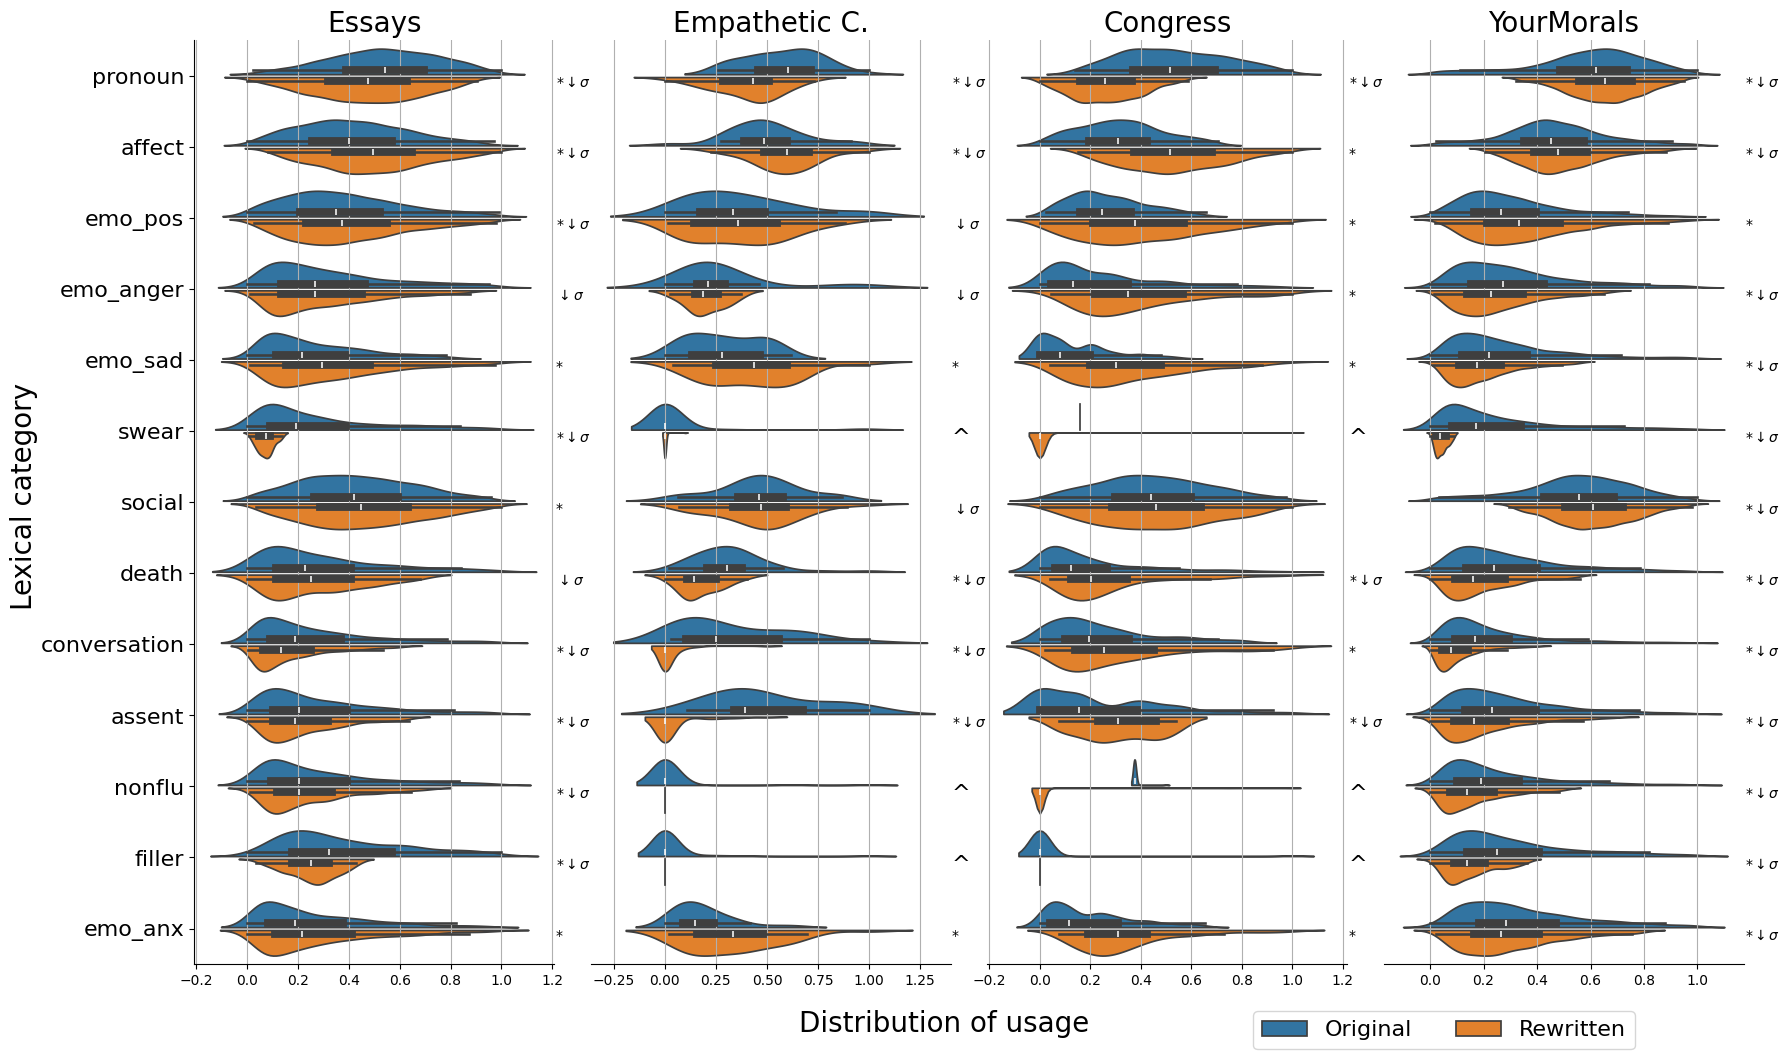

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_52810/1670622415.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


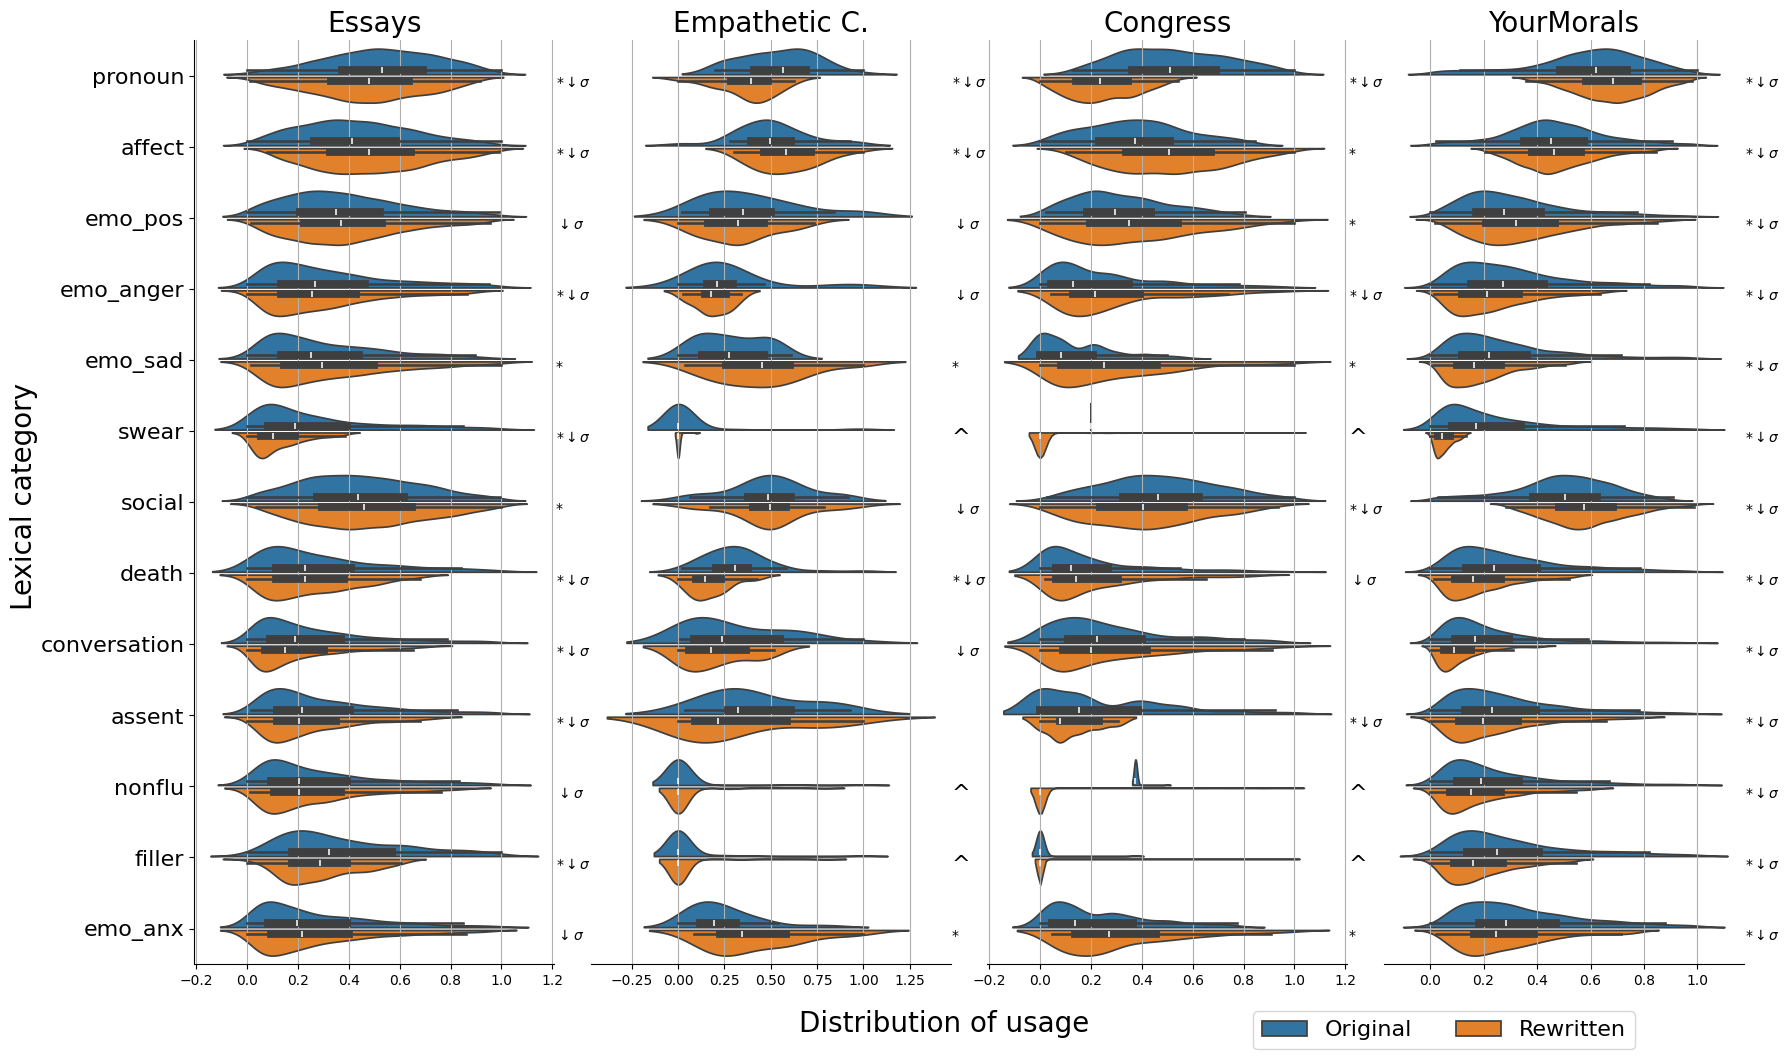

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_52810/1670622415.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


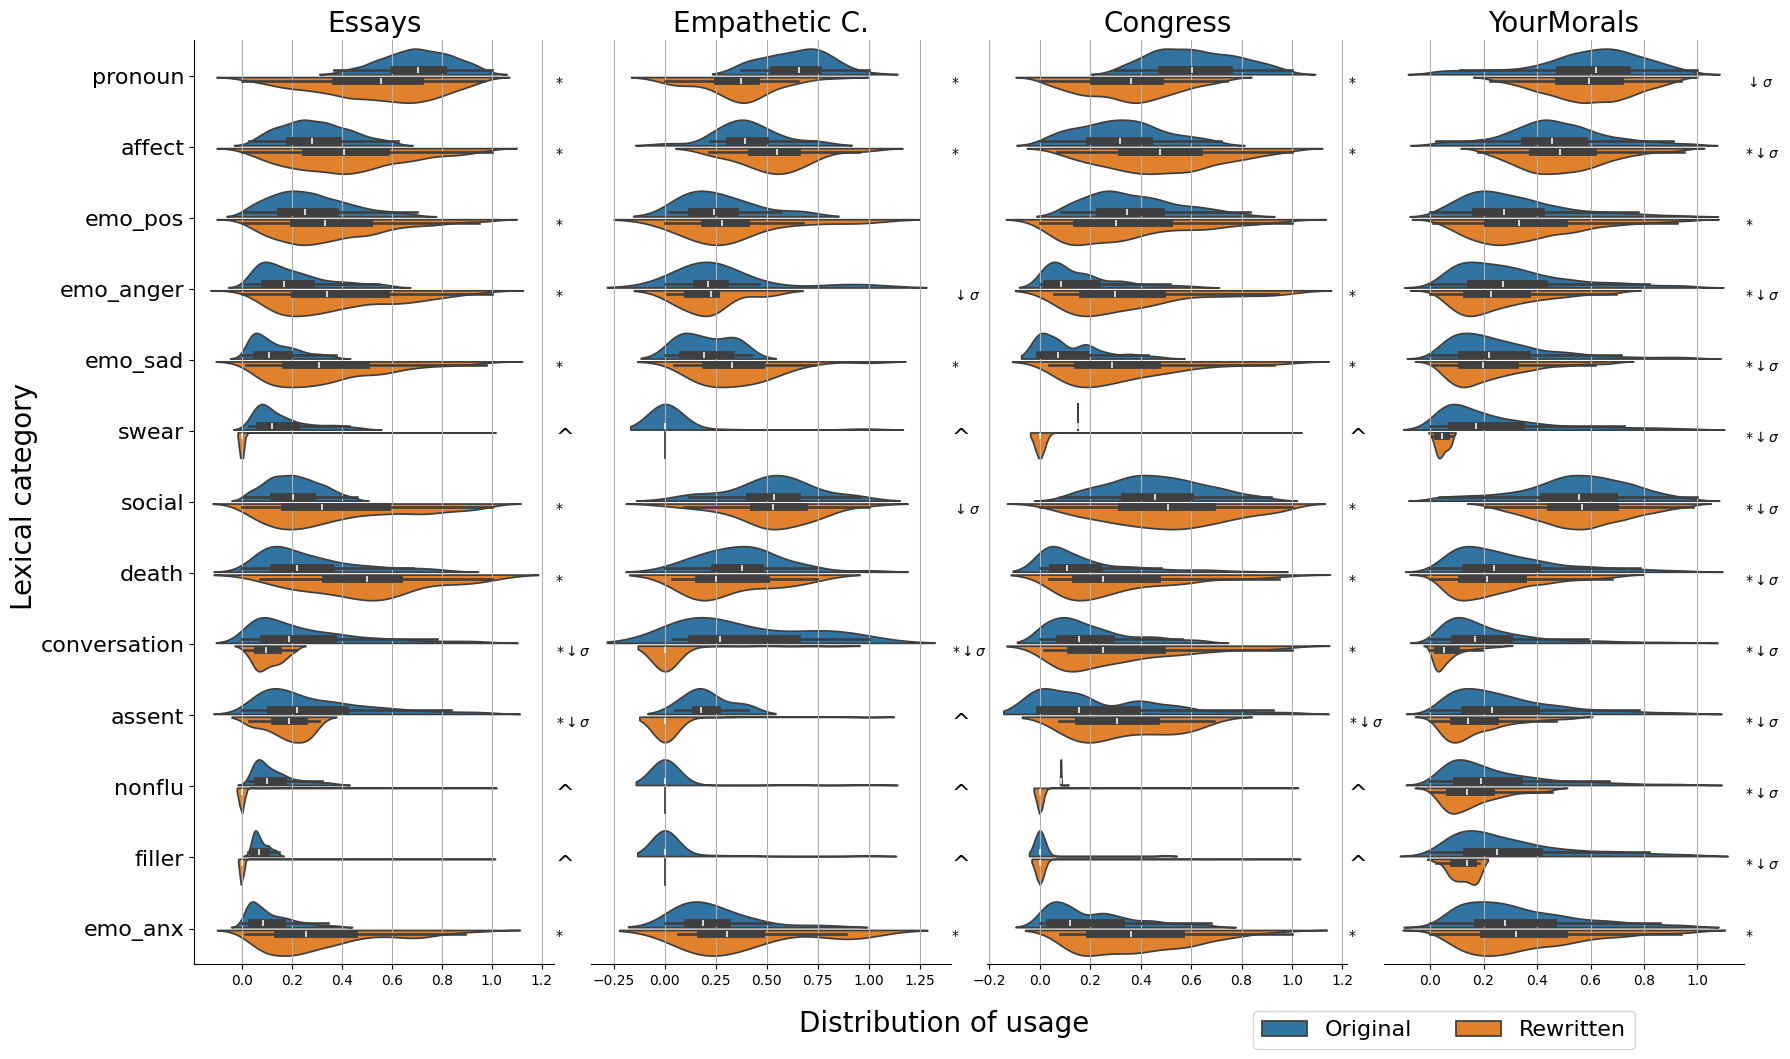

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_52810/1670622415.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(
/Users/zhivar/anaconda3/envs/py310/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:523: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


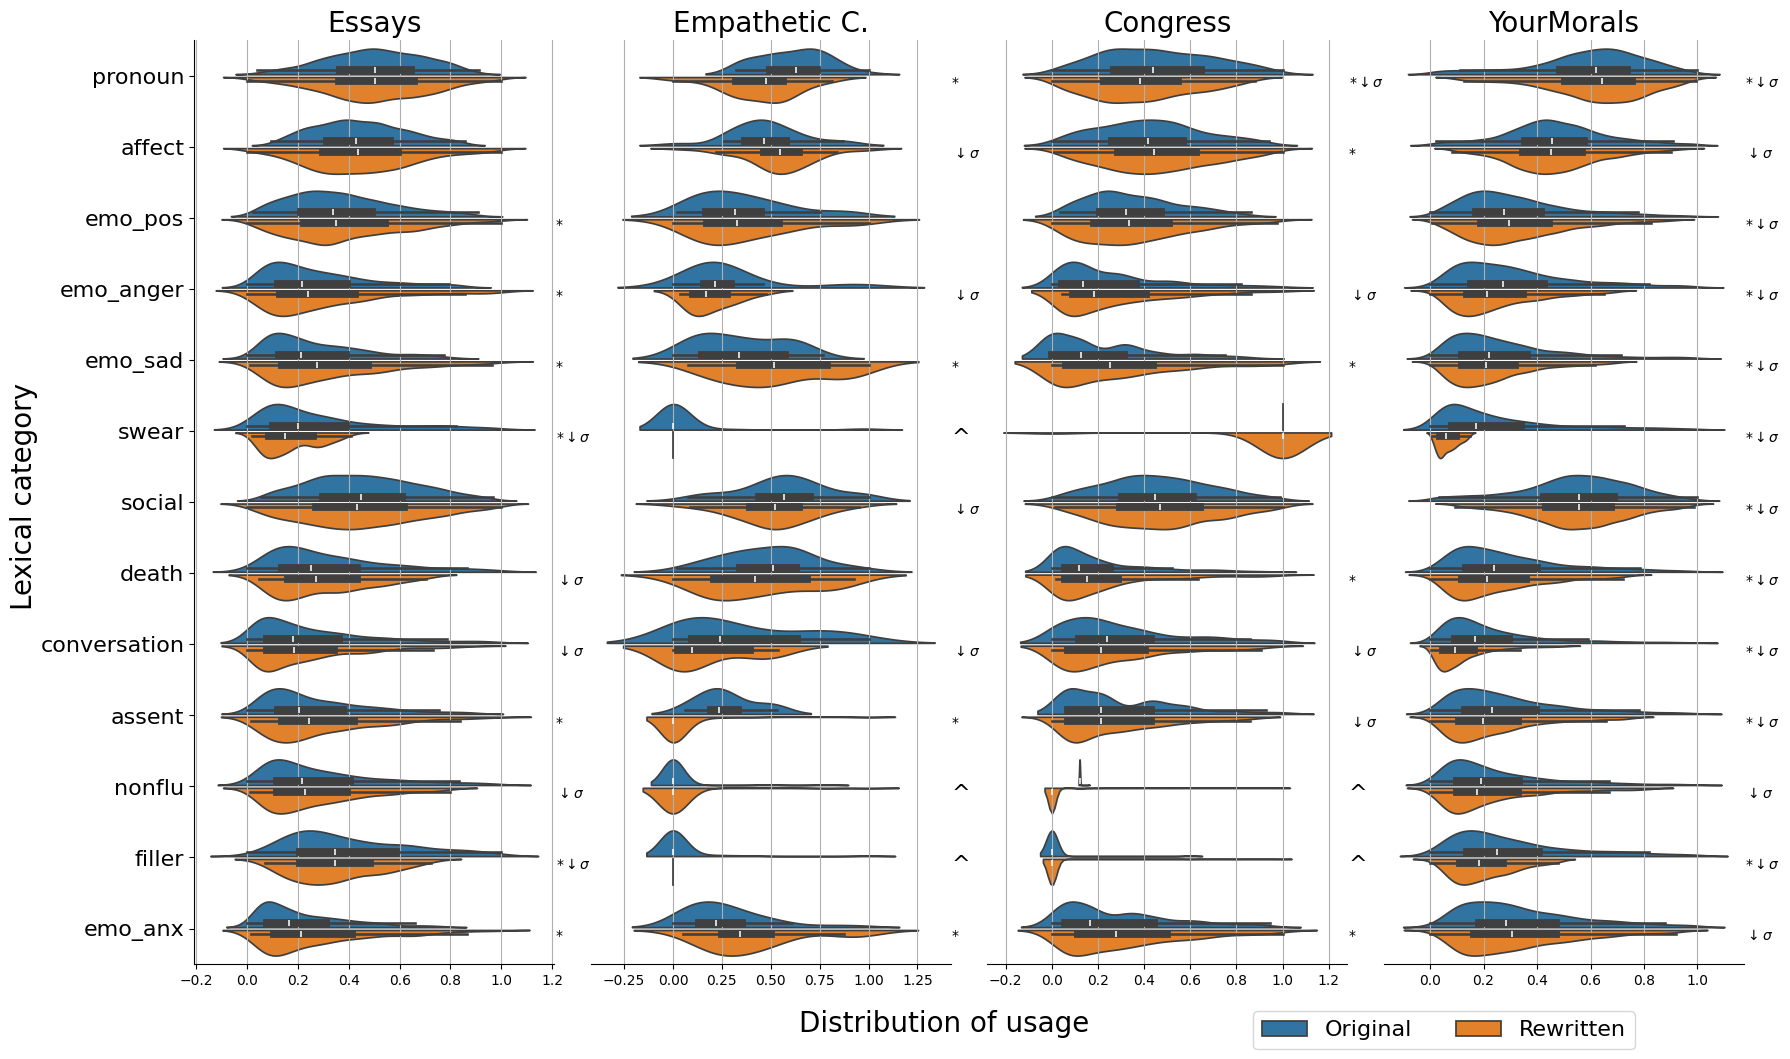

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_52810/1670622415.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


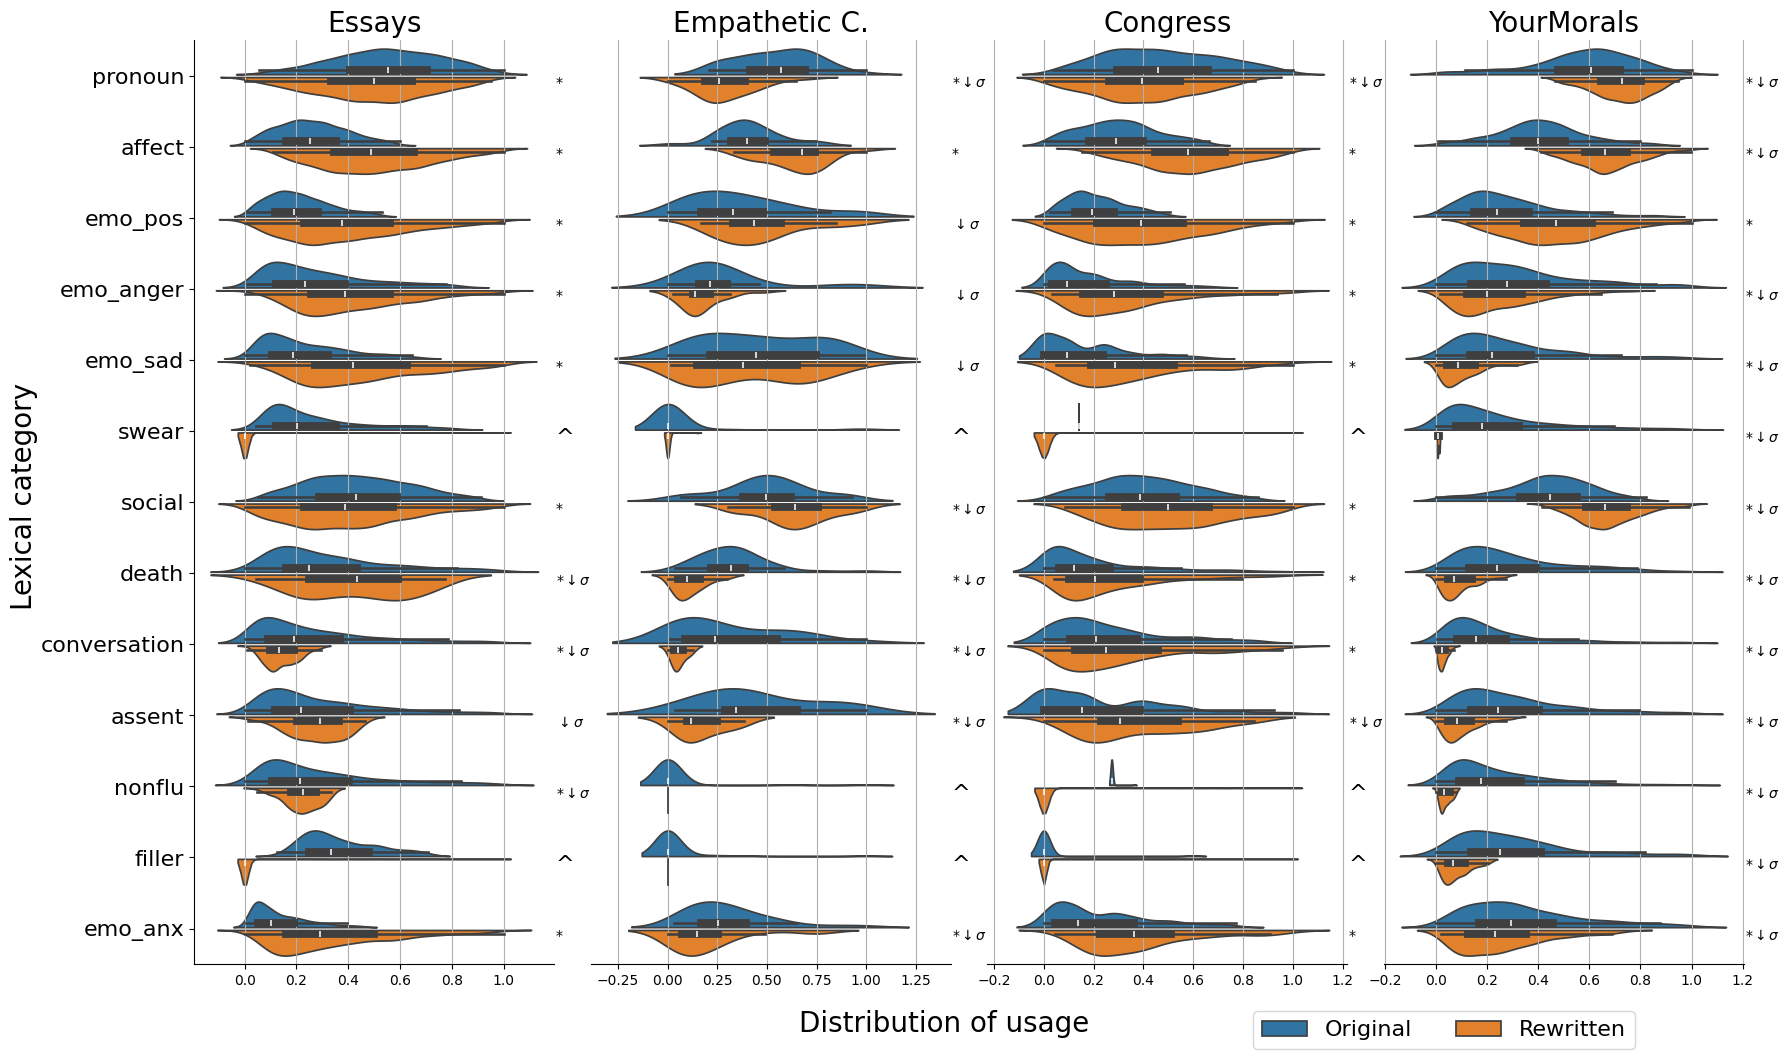

/var/folders/s6/_dcfmqnx4mxbhf22rbww8kwc0000gp/T/ipykernel_52810/1670622415.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


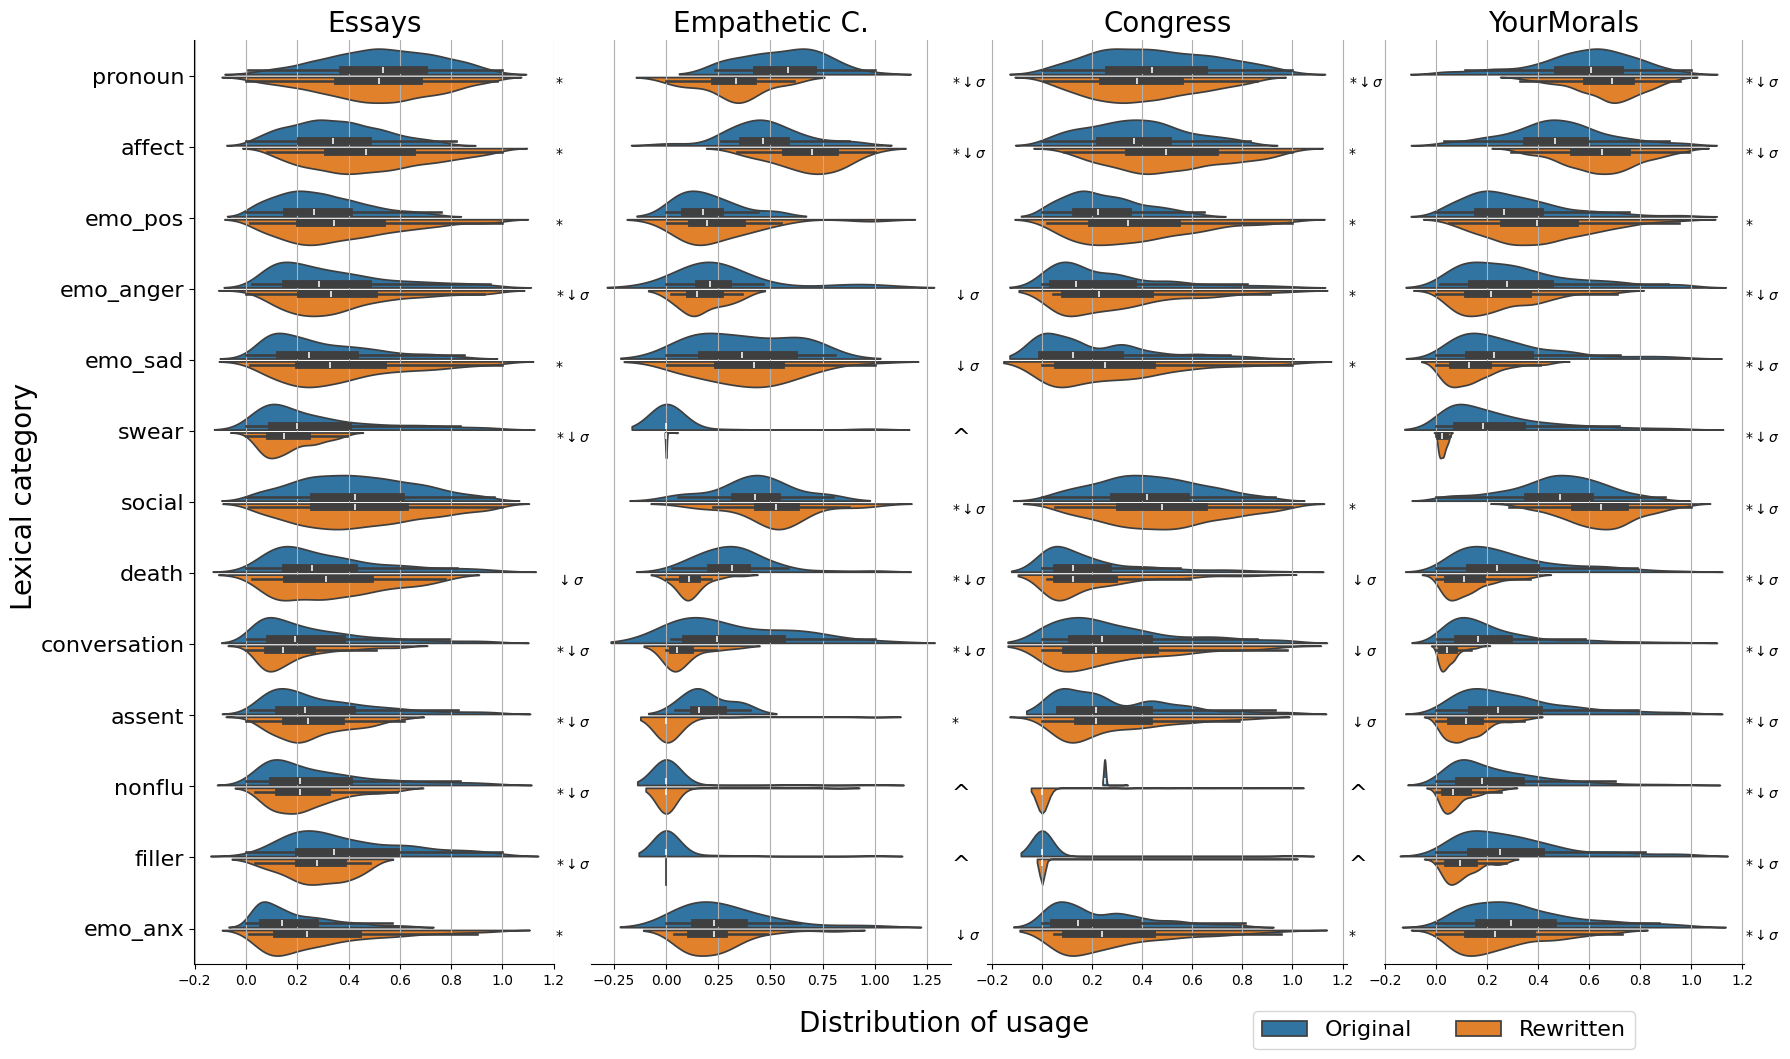

In [412]:
from scipy.stats import ttest_ind, mannwhitneyu, levene

for llm in ["gpt", "gemini", "llama"]:
    for mode in ["rephrase", "syntax_grammar"]:
        fig, axs = plt.subplots(1, 4, figsize=(20, 12), sharey=True)

        for index, (ax, dataset) in enumerate(zip(axs, df["dataset"].unique())):

            data_source = (
                get_df_with_dist_spread(
                    df[
                        (df["col"].isin(general_categories_that_are_reduced))
                        & (df["mode"] == mode)
                        & (df["llm"] == llm)
                        & (df["dataset"] == dataset)
                    ]
                )
                .set_index("col")
                .loc[general_categories_that_are_reduced]
                .reset_index()
            )
            sns.violinplot(
                data=data_source,
                y="col",
                x="value",
                hue="Text",
                split=True,
                inner="box",
                gap=0.1,
                common_norm=True,
                density_norm="width",
                ax=ax,
            )

            col_to_p_value = {}
            variance_lower = {}
            col_to_variance_p_values = {}
            for col in general_categories_that_are_reduced:
                col_filtered_data_source = data_source[data_source["col"] == col]
                col_filtered_original_values = col_filtered_data_source[
                    col_filtered_data_source["Text"] == "Original"
                ]["value"]
                col_filtered_rewritten_values = col_filtered_data_source[
                    col_filtered_data_source["Text"] == "Rewritten"
                ]["value"]

                if np.nonzero(col_filtered_original_values)[0].shape[
                    0
                ] < 10 / 100 * len(col_filtered_original_values) or np.nonzero(
                    col_filtered_rewritten_values
                )[
                    0
                ].shape[
                    0
                ] < 10 / 100 * len(
                    col_filtered_rewritten_values
                ):
                    col_to_p_value[col] = -1
                    variance_lower[col] = -1
                else:
                    _, p_value = ttest_ind(
                        col_filtered_original_values, col_filtered_rewritten_values
                    )
                    col_to_p_value[col] = p_value
                    variance_lower[col] = np.var(col_filtered_original_values) > np.var(
                        col_filtered_rewritten_values
                    )

            significance_level = 0.05

            ax.set_title(DATASET_TO_DATASET_NAME[dataset], fontsize=20)
            if index == 0:
                # change the font of the y tick labels to be bigger
                ax.set_yticklabels(
                    ax.get_yticklabels(),
                    fontsize=16,
                )
            # remove all the x axis labels
            ax.set_xlabel("")
            ax.set_ylabel("")
            # ax.set_xlim(ax.get_xlim()[0], 0.8)  # from what was the minimum to 0.6
            ax.get_legend().remove()
            ax.grid(axis="x")
            # remove the upper and right spines
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            # if it's not the first one, remove the left spine too
            if index != 0:
                ax.spines["left"].set_visible(False)
                # also remove the ticks on the left
                ax.tick_params(left=False)
            # if dataset == "facebook":
            # ax.set_xlim(ax.get_xlim()[0], 0.5)
            # if dataset == "essays":
            # ax.set_xlim(ax.get_xlim()[0], 0.85)

            # for each col that is on different y values on the plot, if the p value is less than the significance level, put a star on the plot in front of the end of the x limit
            for col, p_value in col_to_p_value.items():
                if p_value == -1:
                    ax.text(
                        ax.get_xlim()[1] + 0.005,
                        general_categories_that_are_reduced.index(col) + 0.1,
                        "^",
                        fontsize=16,
                        verticalalignment="center",
                    )
                elif p_value < significance_level and variance_lower[col]:
                    ax.text(
                        ax.get_xlim()[1] + 0.005,
                        general_categories_that_are_reduced.index(col) + 0.1,
                        "*" + r"$\downarrow\sigma$",
                        fontsize=10,
                        verticalalignment="center",
                    )
                elif p_value < significance_level and not variance_lower[col]:
                    ax.text(
                        ax.get_xlim()[1] + 0.005,
                        general_categories_that_are_reduced.index(col) + 0.1,
                        "*",
                        fontsize=10,
                        verticalalignment="center",
                    )
                elif p_value >= significance_level and variance_lower[col]:
                    ax.text(
                        ax.get_xlim()[1] + 0.005,
                        general_categories_that_are_reduced.index(col) + 0.1,
                        r"$\downarrow\sigma$",
                        fontsize=10,
                        verticalalignment="center",
                    )

        # put the y axis label for the figure as the Lexical Category
        fig.text(
            0.5,
            0.06,
            "Distribution of usage",
            ha="center",
            va="center",
            fontsize=20,
        )
        # and for the y axis, put the dataset name
        fig.text(
            0.04,
            0.5,
            "Lexical category",
            ha="center",
            va="center",
            rotation="vertical",
            fontsize=20,
        )

        # put the legend under the whole thing in two columns
        handles, labels = ax.get_legend_handles_labels()
        fig.legend(
            handles,
            labels,
            loc="lower center",
            ncol=2,
            bbox_to_anchor=(0.75, 0.03),
            fontsize=16,
        )
        fig.subplots_adjust(hspace=0.0, wspace=0.10)
        plt.savefig(
            f"figures/general_categories_differences_{llm}_{mode}.png",
            bbox_inches="tight",
        )
        plt.show()